# Poincloud rotor estimation

Consider the following challenge. We are presented with an input pointcloud $p_i$, and an output pointcloud $q_i = R[p_i] + \eta_i$, where $R$ is an unknown tranformation, and $\eta_i$ is Gaussian noise. The challenge is to reconstruct the transformation $R$.

In order to do this, we construct a symbolic tranformation $R$, whose entries are `symfit.Parameter` objects. We can then use `symfit` to find the rotor $R$.

In [1]:
from kingdon import Algebra
from symfit import Fit, Model, CallableModel, Variable, Parameter, Eq, Mul
from symfit.core.minimizers import *
import numpy as np
import matplotlib.pyplot as plt

We set up the number of points `n_points` in the pointcloud, the number of (Euclidean) dimensions of the modeling space `d`, and the standard deviation `sig` of the Gaussian distribution.

In [2]:
n_points = 10
d = 2
sig = 0.02

In [6]:
point_vals = np.zeros((d+1, n_points))
noise_vals = np.zeros((d+1, n_points))
point_vals[0, :] = np.ones(n_points)
point_vals[1:d+1, :] = np.random.random((d, n_points))
noise_vals[1:d+1, :] = np.random.normal(0.0, sig, (d, n_points))

In [7]:
alg = Algebra(d, 0, 1)

Create the points and noise as pseudovector of grade `d`.

In [8]:
noise = alg.purevector(noise_vals, grade=d)
p = alg.purevector(point_vals, grade=d)
p

MultiVector(algebra=Algebra(p=2, q=0, r=1, cse=True, precompute='none', numba=False, graded=False, simplify=True), _values=array([[1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ],
       [0.54249339, 0.00187754, 0.88934931, 0.14371307, 0.90024069,
        0.16091466, 0.79154578, 0.8069197 , 0.08935312, 0.71837907],
       [0.46277455, 0.50690105, 0.93836961, 0.33780138, 0.21474948,
        0.09130718, 0.67021727, 0.37623112, 0.16948978, 0.31433891]]), _keys=(3, 5, 6))

As the input rotor $R$, we use a translation by $2$ in the $\mathbb{e}_{13}$ direction, followed by a rotation around $\mathbb{e}_{12}$.

In [9]:
t = np.pi/3
T = alg.multivector({0: 1, 5: 1})
print(T)
R = alg.multivector({0: np.cos(t), 3: np.sin(t)})
R = R*T
print(R)
print(R.normsq())

(1) * 1 + (1) * e13
(0.5000000000000001) * 1 + (0.8660254037844386) * e12 + (0.5000000000000001) * e13 + (-0.8660254037844386) * e23
(1.0) * 1 + (0.0) * e12 + (0.0) * e13 + (0.0) * e23


We can now create the transformed pointcloud $q$.

In [10]:
q = R.conj(p) + noise
print(q)

([1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]) * e12 + ([1.88101687 2.16664797 2.12831565 1.95533762 1.48204906 1.73949724
 1.91198636 1.66356202 1.80505835 1.67581711]) * e13 + ([-1.70253249 -1.25262509 -2.21694347 -1.28787096 -1.87394245 -1.21644782
 -2.02445395 -1.89602809 -1.10909076 -1.78311012]) * e23


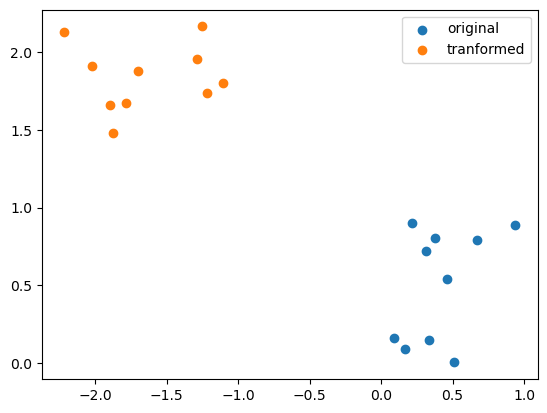

In [11]:
plt.scatter(p[6], p[5], label='original')
plt.scatter(q[6], q[5], label='tranformed')
plt.legend()

We will now setup a symfit model to describe this transformation, where the rotor $R$ consists of `Parameter`'s, and the pointclouds $p$ and $q$ are symfit `Variable`'s.

In [13]:
R_par = alg.evenmv(name='R', symbolcls=Parameter)
p_var = alg.purevector(name='p', symbolcls=Variable, grade=d)
q_var = alg.purevector(name='q', symbolcls=Variable, grade=d)
print(R_par)
print(p_var)
print(q_var)

(R) * 1 + (R12) * e12 + (R13) * e13 + (R23) * e23
(p12) * e12 + (p13) * e13 + (p23) * e23
(q12) * e12 + (q13) * e13 + (q23) * e23


In [14]:
p_var_trans = R_par.conj(p_var)
model = Model({q_var[k]: expr for k, expr in p_var_trans.items()})
model

Prepare the data for `symfit`.

In [15]:
p_data_dict = {p_var[k].name: p[k] for k in p_var.keys()}
q_data_dict = {q_var[k].name: q[k] for k in q_var.keys()}
datadict = p_data_dict | q_data_dict
datadict

{'p12': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 'p13': array([0.54249339, 0.00187754, 0.88934931, 0.14371307, 0.90024069,
        0.16091466, 0.79154578, 0.8069197 , 0.08935312, 0.71837907]),
 'p23': array([0.46277455, 0.50690105, 0.93836961, 0.33780138, 0.21474948,
        0.09130718, 0.67021727, 0.37623112, 0.16948978, 0.31433891]),
 'q12': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 'q13': array([1.88101687, 2.16664797, 2.12831565, 1.95533762, 1.48204906,
        1.73949724, 1.91198636, 1.66356202, 1.80505835, 1.67581711]),
 'q23': array([-1.70253249, -1.25262509, -2.21694347, -1.28787096, -1.87394245,
        -1.21644782, -2.02445395, -1.89602809, -1.10909076, -1.78311012])}

Initiate a `symfit.Fit` object with the model and data. We additionally supply the demand $R \widetilde{R} = 1$, since rotors should be normalized (i.e., othonormal transformations).

In [16]:
constraints = [
    Eq(R_par.normsq()[0], 1)
]
fit = Fit(model, **datadict, constraints=constraints)

In [17]:
results = fit.execute()
print(results)


Parameter Value        Standard Deviation
R         5.108861e-01 1.055367e-02
R12       8.596484e-01 7.296990e-03
R13       4.858532e-01 1.842247e-02
R23       -8.692481e-01 9.055921e-03
Status message         Optimization terminated successfully
Number of iterations   24
Objective              <symfit.core.objectives.LeastSquares object at 0x0000024A2994BD00>
Minimizer              <symfit.core.minimizers.SLSQP object at 0x0000024A29993790>

Goodness of fit qualifiers:
chi_squared            0.006075606510390592
objective_value        0.003037803255195296
r_squared              0.9965636446731153

Constraints:
--------------------
Question: R**2 + R12**2 - 1 == 0?
Answer:   4.747247039915692e-11




`symfit` has used SLSQP because of the constraint, and we see that we have high accuracy on this constraint. Let us print the reconstructed rotor and it's norm. Furthermore, we can now apply $\widetilde{R}$ to $q$ to transform it back to the location of $p$ so we can visually inspect the quality of the reconstruction.

In [18]:
R_re = R_par(**results.params)
print(R_re)
print(R_re.normsq())

(0.5108861009186112) * 1 + (0.8596484118147669) * e12 + (0.48585315153371916) * e13 + (-0.8692480906253773) * e23
(1.0000000000474725) * 1 + (0.0) * e12 + (0.0) * e13 + (5.551115123125783e-17) * e23


In [19]:
p_reconstructed = (~R_re).conj(q)

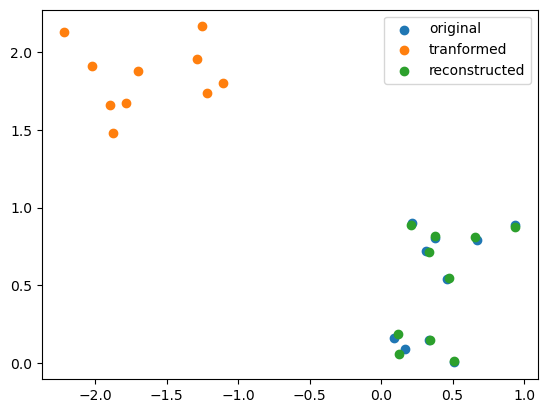

In [20]:
plt.scatter(p[6], p[5], label='original')
plt.scatter(q[6], q[5], label='tranformed')
plt.scatter(p_reconstructed[6], p_reconstructed[5], label='reconstructed')
plt.legend()

We see that we have excellent agreement between the original and reconstructed pointclouds.